<a href="https://colab.research.google.com/github/Yasi438/Network-Slicing-using-Machine-Learing/blob/main/networkslicing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

While running the code be careful of the columns name because at the orgirnal dataset saparated the columns names with dot but at the end we used in some part with dash, that is because during the clustering we tried to write the name of the cluster using the  if we want to do clustering with pyspark but we didn't and with that dot saperated columns name we did the clustering

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler




th orgirnal dataset is availabe in kaggle at this address /kaggle/input/ip-network-traffic-flows-labeled-with-87-apps
 and the mounting the dataset from the drive

Reading the dataset, the reason we didn't take the first 100k rows of the dataset is that there might be some kind of sorting done on it so we made block by block

In [ ]:
# Assuming your dataset is in a CSV file
dataset=pd.read_csv('/content/drive/MyDrive/dataset/filtered_datase.csv')

# Number of rows in each block
block_size = 100000
# sample per block
rows_per_block = 2850

# Create an empty DataFrame to store the sampled data
sampled_data = pd.DataFrame()
# Loop through each block and sample rows
for i in range(0, len(dataset), block_size):
    block = dataset.iloc[i:i + block_size]
    sampled_block = block.sample(n=rows_per_block, random_state=42)
    sampled_data = pd.concat([sampled_data, sampled_block])

# Reset the index of the sampled data
sampled_data.reset_index(drop=True, inplace=True)

# Save the sampled dataset to a new CSV file
sampled_data.to_csv("dataset.csv", index=False)


In [ ]:
df=pd.read_csv('/content/dataset.csv')

Chaninging the timestamp to int

In [ ]:
df

,Flow.IAT.Max,Destination.IP,Source.Port,Source.IP,Fwd.IAT.Total,Init_Win_bytes_backward,Destination.Port,Fwd.Packet.Length.Max,Timestamp,Subflow.Bwd.Bytes,Init_Win_bytes_forward,Bwd.Packet.Length.Mean,Bwd.Packet.Length.Max,Fwd.Packet.Length.Std,Flow.Duration
0,25756.0,192.168.10.80,3128,10.200.7.4,0.0,62,55317,6,26/04/201711:15:27,6,298,6.000000,6,0.000000,25756
1,115503.0,10.200.7.7,56803,10.230.1.155,261137.0,-1,3128,517,26/04/201711:14:36,0,8192,0.000000,0,197.883207,261137
2,271.0,192.168.10.11,3128,10.200.7.4,271.0,-1,53700,291,26/04/201711:13:08,0,308,0.000000,0,164.544827,271
3,2663.0,192.168.10.143,3128,10.200.7.4,0.0,63,53118,6,26/04/201711:14:39,6,437,6.000000,6,0.000000,2663
4,2661.0,192.168.180.37,3128,10.200.7.9,0.0,32593,2468,0,26/04/201711:12:34,0,215,0.000000,0,0.000000,2874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102595,249164.0,10.200.7.8,53488,192.168.90.72,249273.0,-1,3128,85,15/05/201705:18:40,0,2053,0.000000,0,43.270082,249273
102596,45004404.0,10.200.7.6,56234,192.168.32.106,87214479.0,696,3128,1396,15/05/201705:23:52,16742,2053,597.928571,1436,719.393346,87214479
102597,44999987.0,10.200.7.8,56792,172.18.1.217,45820776.0,756,3128,240,15/05/201705:18:31,3825,8192,255.000000,1460,106.070731,65273220
102598,29046560.0,10.200.7.218,443,64.233.186.189,112843150.0,1321,35185,115,15/05/201705:27:20,528,58,33.000000,226,32.965024,112843332


changing the timestap into a numerical value, Unix timestamps
first it will change from string to int then from int to nanosecands and then to seconds



In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y%H:%M:%S').astype('int64') // 10**9


changing the ip address to numerical values

LabelEncoder is a method from the sklearn.preprocessing module.
It assigns a unique integer to each unique value (category) in a column.
For example:
Original IPs like 192.168.1.1, 10.0.0.1, and 172.16.0.1 might be encoded as 0, 1, and 2.
The mapping is based on the unique order in the data.




In [ ]:
ip_encoder = LabelEncoder()
df['Destination.IP'] = ip_encoder.fit_transform(df['Destination.IP'])
df['Source.IP'] = ip_encoder.fit_transform(df['Source.IP'])

In [ ]:
df

,Flow.IAT.Max,Destination.IP,Source.Port,Source.IP,Fwd.IAT.Total,Init_Win_bytes_backward,Destination.Port,Fwd.Packet.Length.Max,Timestamp,Subflow.Bwd.Bytes,Init_Win_bytes_forward,Bwd.Packet.Length.Mean,Bwd.Packet.Length.Max,Fwd.Packet.Length.Std,Flow.Duration
0,25756.0,2312,3128,20,0.0,62,55317,6,1493205327,6,298,6.000000,6,0.000000,25756
1,115503.0,37,56803,35,261137.0,-1,3128,517,1493205276,0,8192,0.000000,0,197.883207,261137
2,271.0,2211,3128,20,271.0,-1,53700,291,1493205188,0,308,0.000000,0,164.544827,271
3,2663.0,2243,3128,20,0.0,63,53118,6,1493205279,6,437,6.000000,6,0.000000,2663
4,2661.0,2596,3128,25,0.0,32593,2468,0,1493205154,0,215,0.000000,0,0.000000,2874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102595,249164.0,38,53488,1743,249273.0,-1,3128,85,1494825520,0,2053,0.000000,0,43.270082,249273
102596,45004404.0,36,56234,1128,87214479.0,696,3128,1396,1494825832,16742,2053,597.928571,1436,719.393346,87214479
102597,44999987.0,38,56792,251,45820776.0,756,3128,240,1494825511,3825,8192,255.000000,1460,106.070731,65273220
102598,29046560.0,33,443,2173,112843150.0,1321,35185,115,1494826040,528,58,33.000000,226,32.965024,112843332


In [ ]:
df.drop_duplicates( inplace=True)

In [ ]:
df.dropna(inplace=True)

In [ ]:
pandas_df=df.copy()

In [ ]:
k_values = range(2, 10)

# Initialize lists to store clustering metrics
inertia = []
silhouette_scores = []
davies_bouldin_scores = []

# Run K-means for different k values
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df)
    labels = kmeans.labels_

    # Calculate metrics
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df, labels))
    davies_bouldin_scores.append(davies_bouldin_score(df, labels))

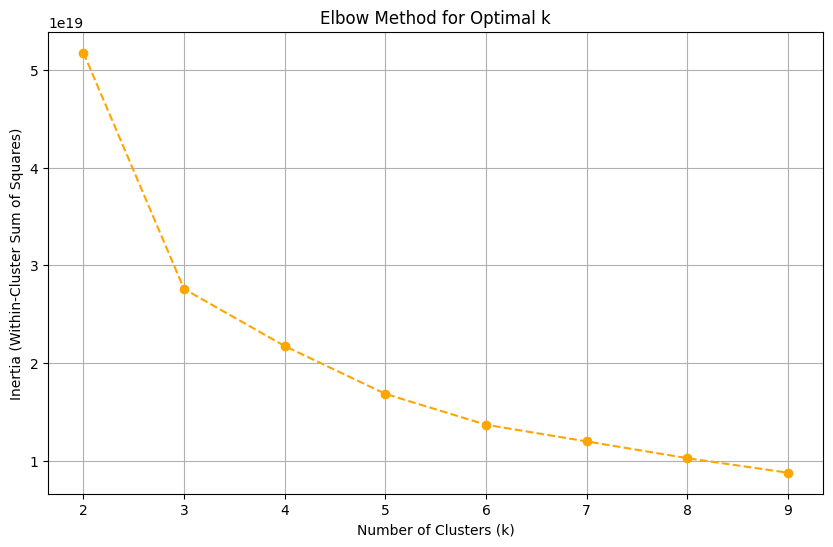

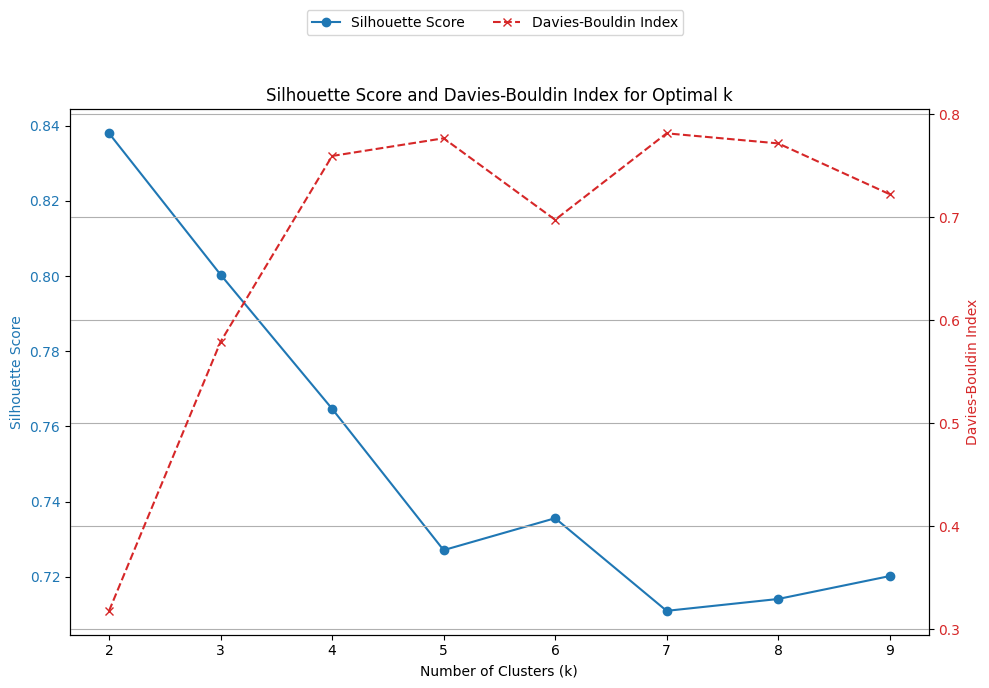

In [ ]:
# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', linestyle='--', color='orange')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Plot Silhouette Score and Davies-Bouldin Index
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score', color='tab:blue')
ax1.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='tab:blue', label='Silhouette Score')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Davies-Bouldin Index', color='tab:red')
ax2.plot(k_values, davies_bouldin_scores, marker='x', linestyle='--', color='tab:red', label='Davies-Bouldin Index')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Silhouette Score and Davies-Bouldin Index for Optimal k')
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.grid(True)
plt.show()



Davies-Bouldin Index (DBI):
Measures the average similarity between clusters. Lower values are better (indicating well-separated clusters).

Silhouette Score:
Measures how well-separated clusters are. Higher values are better (indicating clear separation between clusters).

In [ ]:

optimal_k_dbi = k_values[davies_bouldin_scores.index(min(davies_bouldin_scores))]
optimal_k_silhouette = k_values[silhouette_scores.index(max(silhouette_scores))]
inertia_diff = np.diff(inertia)
relative_drops = -inertia_diff / inertia[:-1]

# Find the k value with the maximum relative drop
elbow_index = np.argmax(relative_drops)
optimal_k_elbow = k_values[elbow_index + 1]

print(f"Optimal k (DBI): {optimal_k_dbi}")
print(f"Optimal k (Silhouette): {optimal_k_silhouette}")
print(f"Optimal k (Elbow): {optimal_k_elbow}")

Optimal k (DBI): 2
Optimal k (Silhouette): 2
Optimal k (Elbow): 3


In [ ]:
df

,Flow.IAT.Max,Destination.IP,Source.Port,Source.IP,Fwd.IAT.Total,Init_Win_bytes_backward,Destination.Port,Fwd.Packet.Length.Max,Timestamp,Subflow.Bwd.Bytes,Init_Win_bytes_forward,Bwd.Packet.Length.Mean,Bwd.Packet.Length.Max,Fwd.Packet.Length.Std,Flow.Duration
0,25756.0,2312,3128,20,0.0,62,55317,6,1493205327,6,298,6.000000,6,0.000000,25756
1,115503.0,37,56803,35,261137.0,-1,3128,517,1493205276,0,8192,0.000000,0,197.883207,261137
2,271.0,2211,3128,20,271.0,-1,53700,291,1493205188,0,308,0.000000,0,164.544827,271
3,2663.0,2243,3128,20,0.0,63,53118,6,1493205279,6,437,6.000000,6,0.000000,2663
4,2661.0,2596,3128,25,0.0,32593,2468,0,1493205154,0,215,0.000000,0,0.000000,2874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102595,249164.0,38,53488,1743,249273.0,-1,3128,85,1494825520,0,2053,0.000000,0,43.270082,249273
102596,45004404.0,36,56234,1128,87214479.0,696,3128,1396,1494825832,16742,2053,597.928571,1436,719.393346,87214479
102597,44999987.0,38,56792,251,45820776.0,756,3128,240,1494825511,3825,8192,255.000000,1460,106.070731,65273220
102598,29046560.0,33,443,2173,112843150.0,1321,35185,115,1494826040,528,58,33.000000,226,32.965024,112843332


the reason we chose to go with k=3 is that first the orginal paper opted the k=3 second there would not be much diference between k=2, and 3 since the the dataset is smaller than the orginal dataset, the data would more compact and have less divergence

In [ ]:
optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans_final.fit_predict(df)


In [ ]:
df

,Flow.IAT.Max,Destination.IP,Source.Port,Source.IP,Fwd.IAT.Total,Init_Win_bytes_backward,Destination.Port,Fwd.Packet.Length.Max,Timestamp,Subflow.Bwd.Bytes,Init_Win_bytes_forward,Bwd.Packet.Length.Mean,Bwd.Packet.Length.Max,Fwd.Packet.Length.Std,Flow.Duration,Cluster
0,25756.0,2312,3128,20,0.0,62,55317,6,1493205327,6,298,6.000000,6,0.000000,25756,0
1,115503.0,37,56803,35,261137.0,-1,3128,517,1493205276,0,8192,0.000000,0,197.883207,261137,0
2,271.0,2211,3128,20,271.0,-1,53700,291,1493205188,0,308,0.000000,0,164.544827,271,0
3,2663.0,2243,3128,20,0.0,63,53118,6,1493205279,6,437,6.000000,6,0.000000,2663,0
4,2661.0,2596,3128,25,0.0,32593,2468,0,1493205154,0,215,0.000000,0,0.000000,2874,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102595,249164.0,38,53488,1743,249273.0,-1,3128,85,1494825520,0,2053,0.000000,0,43.270082,249273,0
102596,45004404.0,36,56234,1128,87214479.0,696,3128,1396,1494825832,16742,2053,597.928571,1436,719.393346,87214479,1
102597,44999987.0,38,56792,251,45820776.0,756,3128,240,1494825511,3825,8192,255.000000,1460,106.070731,65273220,2
102598,29046560.0,33,443,2173,112843150.0,1321,35185,115,1494826040,528,58,33.000000,226,32.965024,112843332,1


the reason we did two copy of the dataframe after finding the optimal k using Elbow, DBI and silhoute is that in future use we may bring some changes or add new columns, and if we need the orginal dataframe after clustering should be without change because running the silhoute and clustering takes a lot of time if we run each time.

In [ ]:
application_df=df.copy()
new_df=df.copy()

comparing the Distinartion_port with standard port for each application we can find that which type of application was mostly used within those clusters.

In [ ]:

port_to_app = {
    80: 'HTTP', 443: 'HTTPS', 25: 'SMTP', 587: 'SMTP',
    21: 'FTP', 22: 'SSH', 53: 'DNS', 110: 'POP3', 995: 'POP3',
    3128: 'HTTP_PROXY', 1935: 'YouTube/Streaming', 5222: 'Messaging',
    5223: 'Messaging', 6667: 'IRC', 3478: 'Google Meet', 19302: 'Google Meet',
    5228: 'Facebook', 5229: 'Facebook'
}

# Function to map port numbers to application features
def map_port_to_app(port):
    return port_to_app.get(port, 'Unknown')

# Apply the mapping to the Destination Port column
application_df['Application'] = application_df['Destination.Port'].apply(map_port_to_app)

# Check how many traffic flows belong to each application
application_summary = application_df['Application'].value_counts()

print("Traffic Distribution by Application:")
print(application_summary)


Traffic Distribution by Application:
Application
HTTP_PROXY           41131
HTTPS                27283
Unknown              23166
HTTP                 10769
Facebook               119
DNS                     86
Messaging               29
YouTube/Streaming        5
SSH                      2
Google Meet              1
Name: count, dtype: int64


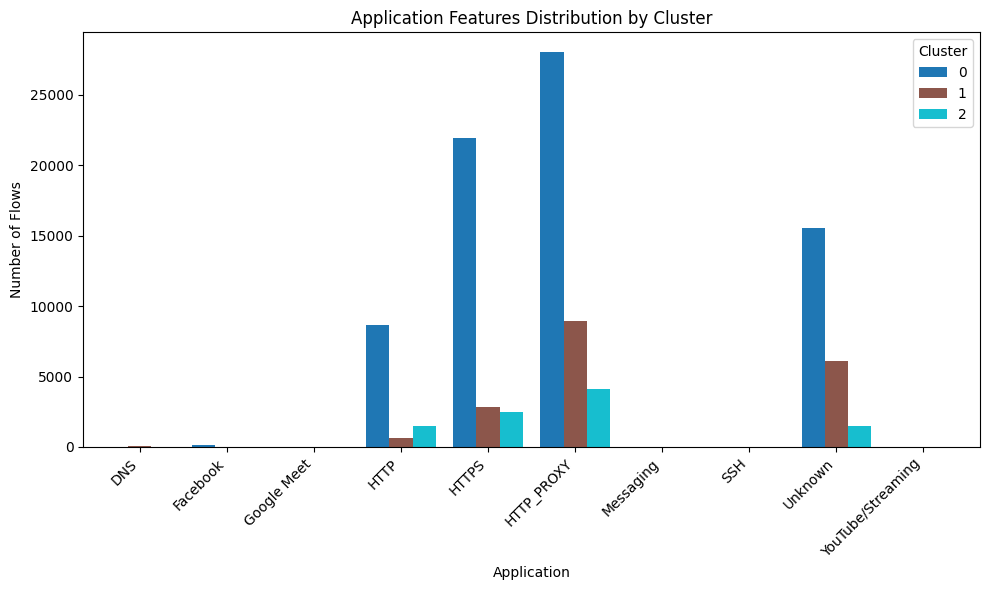

In [ ]:
# Count the number of flows for each application per cluster
app_count_per_cluster = application_df.groupby(['Cluster', 'Application']).size().reset_index(name='Count')

# Pivot the data for grouped bar plotting
app_pivot = app_count_per_cluster.pivot(index='Application', columns='Cluster', values='Count').fillna(0)

# Plot the application distribution as a grouped bar chart
app_pivot.plot(kind='bar', figsize=(10, 6), width=0.8, colormap='tab10')

# Add titles and labels
plt.title("Application Features Distribution by Cluster")
plt.xlabel("Application")
plt.ylabel("Number of Flows")
plt.legend(title="Cluster", loc="upper right")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()


<ipython-input-29-a930f57d2795>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_summary = new_df.groupby(['Cluster', 'Flow_Duration_Bin']).size().unstack(fill_value=0)
<ipython-input-29-a930f57d2795>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iat_summary = new_df.groupby(['Cluster', 'Flow.IAT.Bin']).size().unstack(fill_value=0)


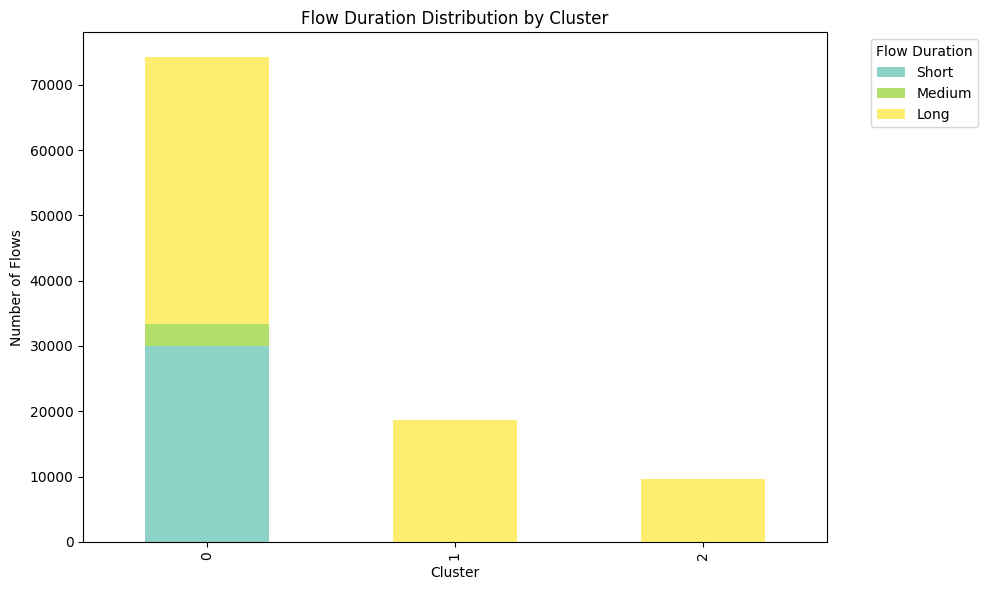

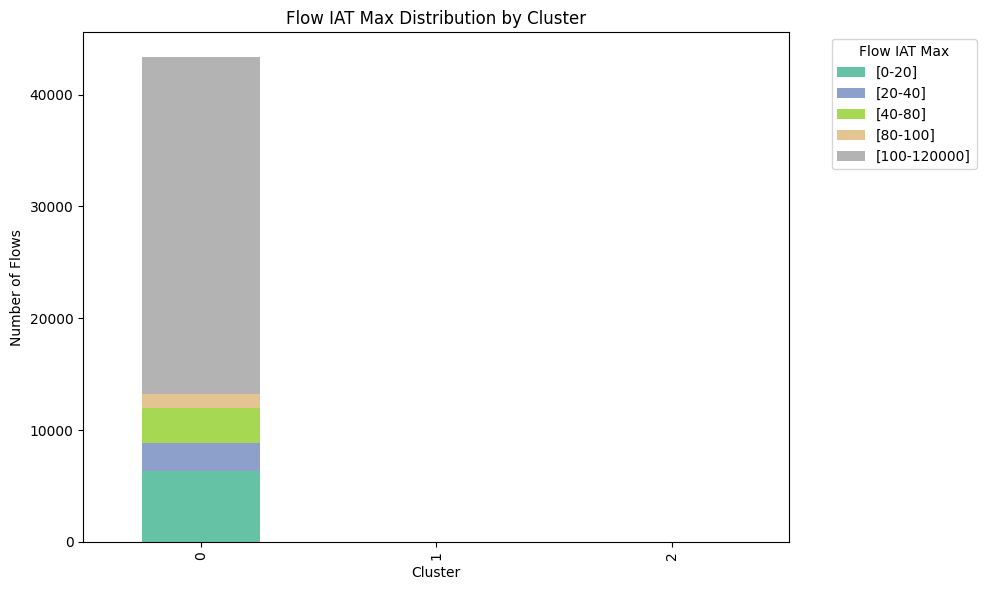

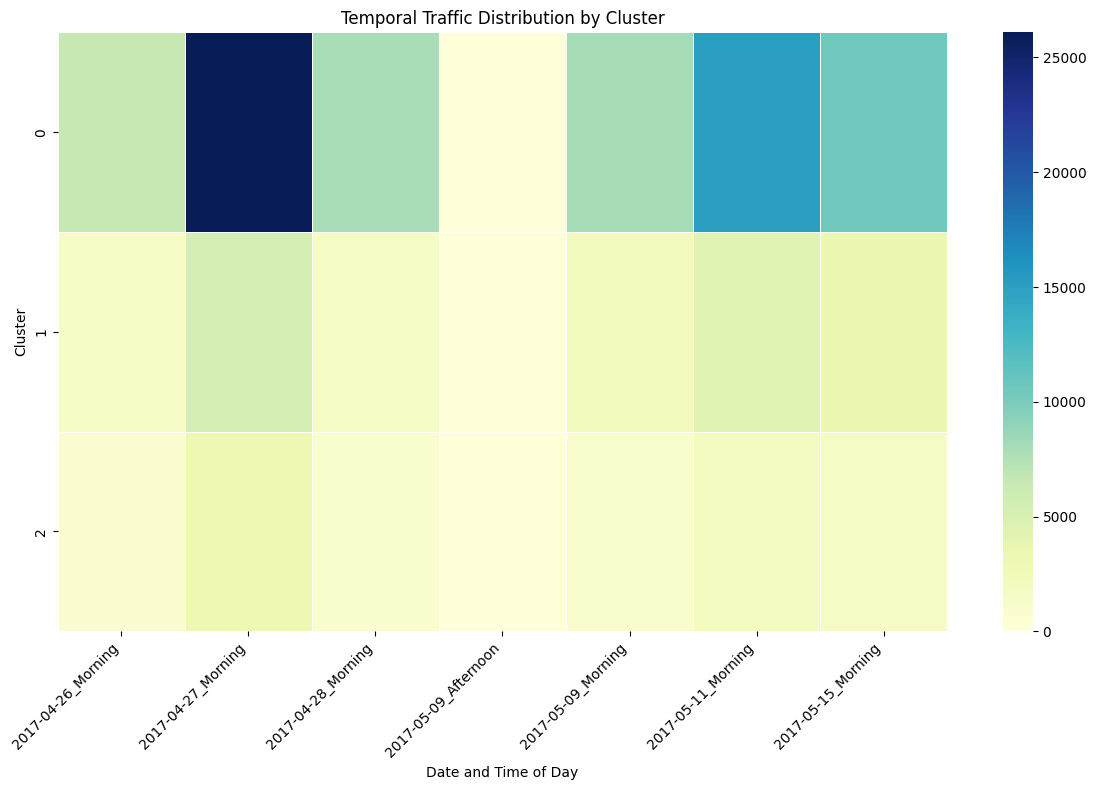

In [ ]:


# Define bins for Flow Duration (Short, Medium, Long)
new_df['Flow_Duration_Bin'] = pd.cut(
    new_df['Flow.Duration'],
    bins=[0, 2000, 10000, new_df['Flow.Duration'].max()],
    labels=['Short', 'Medium', 'Long']
)

# Define bins for Flow IAT Max
new_df['Flow.IAT.Bin'] = pd.cut(
    new_df['Flow.IAT.Max'],
    bins=[0, 20, 40, 80, 100, 120000],
    labels=['[0-20]', '[20-40]', '[40-80]', '[80-100]', '[100-120000]']
)

# Summarize Data for Duration and IAT by Cluster
duration_summary = new_df.groupby(['Cluster', 'Flow_Duration_Bin']).size().unstack(fill_value=0)
iat_summary = new_df.groupby(['Cluster', 'Flow.IAT.Bin']).size().unstack(fill_value=0)

# Plot 1: Stacked Bar Chart for Flow Duration Distribution
duration_summary.plot(kind='bar', stacked=True, colormap='Set3', figsize=(10, 6))
plt.title("Flow Duration Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Flows")
plt.legend(title="Flow Duration", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot 2: Stacked Bar Chart for IAT Distribution
iat_summary.plot(kind='bar', stacked=True, colormap='Set2', figsize=(10, 6))
plt.title("Flow IAT Max Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Flows")
plt.legend(title="Flow IAT Max", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Temporal Heatmap (if timestamps are grouped)
# Convert timestamp to date and part of the day (morning/afternoon)
new_df['Date'] = pd.to_datetime(new_df['Timestamp'], unit='s').dt.date
new_df['Part of Day'] = pd.to_datetime(new_df['Timestamp'], unit='s').dt.hour.map(
    lambda x: 'Morning' if x < 12 else 'Afternoon'
)
new_df['Date_Time'] = new_df['Date'].astype(str) + "_" + new_df['Part of Day']

# Heatmap data
heatmap_data = new_df.groupby(['Cluster', 'Date_Time']).size().unstack(fill_value=0)

# Plot 3: Heatmap for Temporal Traffic Distribution
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.5)
plt.title("Temporal Traffic Distribution by Cluster")
plt.xlabel("Date and Time of Day")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<ipython-input-33-cd667e1d294a>:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bwd_length_summary = new_df.groupby(['Cluster', 'Bwd_Packet_Length_Max_Bin']).size().unstack(fill_value=0)
<ipython-input-33-cd667e1d294a>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fwd_length_summary = new_df.groupby(['Cluster', 'Fwd_Packet_Length_Max_Bin']).size().unstack(fill_value=0)
<ipython-input-33-cd667e1d294a>:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future 

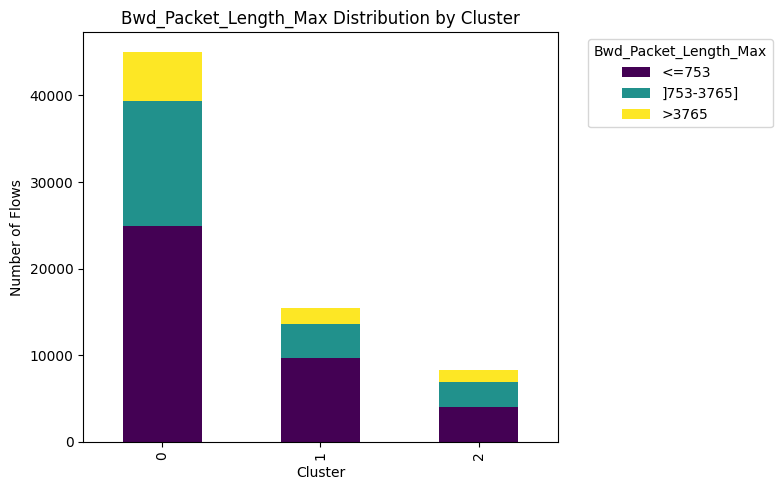

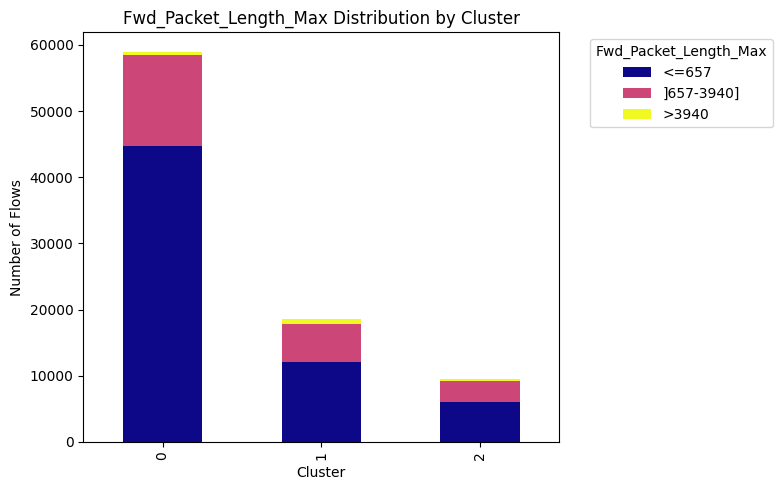

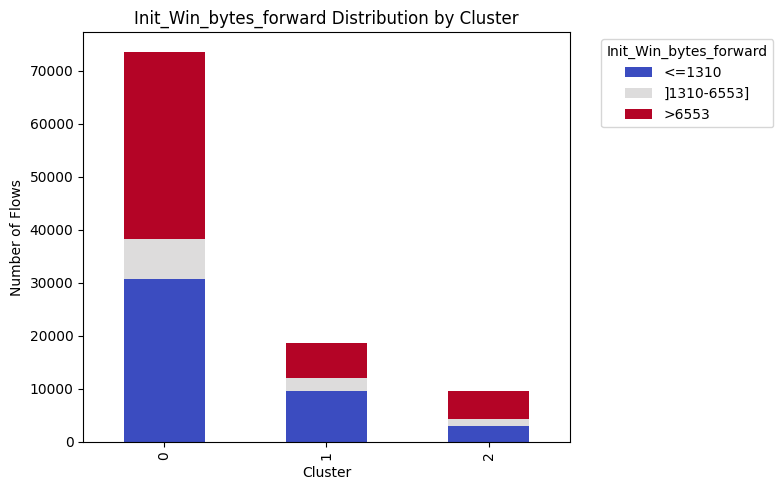

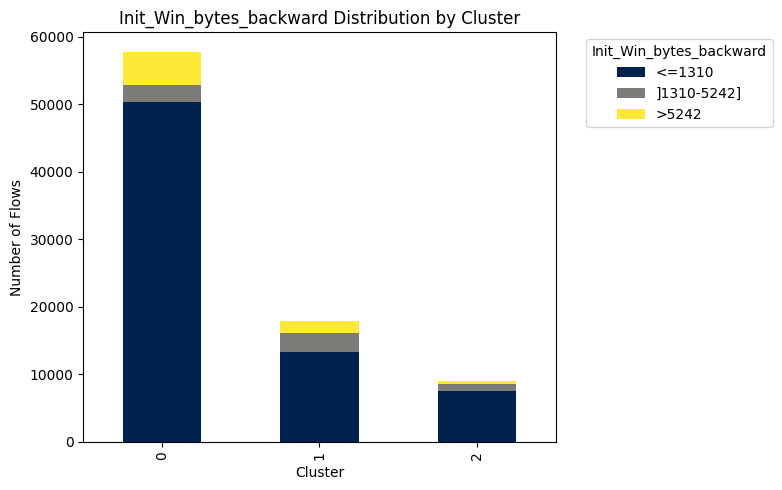

In [ ]:
# Define bins for bandwidth-related features
new_df['Bwd_Packet_Length_Max_Bin'] = pd.cut(
    new_df['Bwd.Packet.Length.Max'],
    bins=[0, 753, 3765, new_df['Bwd.Packet.Length.Max'].max()],
    labels=['<=753', ']753-3765]', '>3765']
)

new_df['Fwd_Packet_Length_Max_Bin'] = pd.cut(
    new_df['Fwd.Packet.Length.Max'],
    bins=[0, 657, 3940, new_df['Fwd.Packet.Length.Max'].max()],
    labels=['<=657', ']657-3940]', '>3940']
)

new_df['Init_Win_bytes_forward_Bin'] = pd.cut(
    new_df['Init_Win_bytes_forward'],
    bins=[0, 1310, 6553, new_df['Init_Win_bytes_forward'].max()],
    labels=['<=1310', ']1310-6553]', '>6553']
)

new_df['Init_Win_bytes_backward_Bin'] = pd.cut(
    new_df['Init_Win_bytes_backward'],
    bins=[0, 1310, 5242, new_df['Init_Win_bytes_backward'].max()],
    labels=['<=1310', ']1310-5242]', '>5242']
)

# Summarize Data for each feature by Cluster
bwd_length_summary = new_df.groupby(['Cluster', 'Bwd_Packet_Length_Max_Bin']).size().unstack(fill_value=0)
fwd_length_summary = new_df.groupby(['Cluster', 'Fwd_Packet_Length_Max_Bin']).size().unstack(fill_value=0)
win_forward_summary = new_df.groupby(['Cluster', 'Init_Win_bytes_forward_Bin']).size().unstack(fill_value=0)
win_backward_summary = new_df.groupby(['Cluster', 'Init_Win_bytes_backward_Bin']).size().unstack(fill_value=0)

# Plot 1: Bwd_Packet_Length_Max Distribution
bwd_length_summary.plot(kind='bar', stacked=True, colormap='viridis', figsize=(8, 5))
plt.title("Bwd_Packet_Length_Max Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Flows")
plt.legend(title="Bwd_Packet_Length_Max", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot 2: Fwd_Packet_Length_Max Distribution
fwd_length_summary.plot(kind='bar', stacked=True, colormap='plasma', figsize=(8, 5))
plt.title("Fwd_Packet_Length_Max Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Flows")
plt.legend(title="Fwd_Packet_Length_Max", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot 3: Init_Win_bytes_forward Distribution
win_forward_summary.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(8, 5))
plt.title("Init_Win_bytes_forward Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Flows")
plt.legend(title="Init_Win_bytes_forward", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot 4: Init_Win_bytes_backward Distribution
win_backward_summary.plot(kind='bar', stacked=True, colormap='cividis', figsize=(8, 5))
plt.title("Init_Win_bytes_backward Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Flows")
plt.legend(title="Init_Win_bytes_backward", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


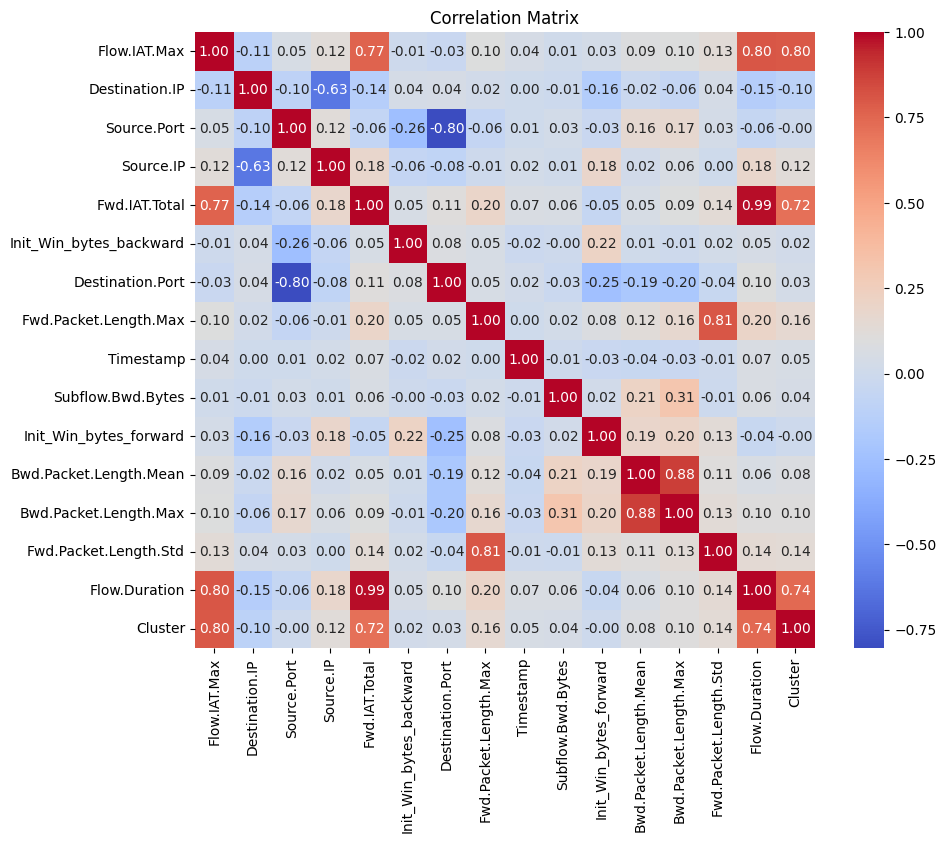

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()
